In [ ]:
!pip install -U sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, random_split
from typing import Callable, Iterable
import torch.nn as nn
from sentence_transformers import SentenceTransformer


In [ ]:
import datasets

In [ ]:
import torch.optim as optim
from transformers.optimization import get_linear_schedule_with_warmup

In [ ]:
import random
import json
import re
import numpy as np
import pandas as pd

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Reading the DataFrame
df_barney = pd.read_csv('/content/drive/MyDrive/МФТИ/nlp2/chatbot/Data/Barney.csv')

df_barney.head()

,Q,A,Context,label
0,What was I doing? Your Uncle Marshall was tak...,"(on the phone) hey, so you know how I've alwa...",What was I doing? Your Uncle Marshall was tak...,1
1,"Hey, you wanna do something tonight?","Okay, meet me at the bar in fifteen minutes, ...","Hey, you wanna do something tonight? | Hey.",2
2,Hey.,Where's your suit!? Just once when I say suit...,Hey. | I did that one time.,2
3,I did that one time.,It was a blazer!,"I did that one time. | You know, ever since ...",2
4,"You know, ever since college it's been Marsha...",I see what this is about. Have you forgotten ...,"You know, ever since college it's been Marsha...",1


In [ ]:
#setting a random seed and some other things for reproducibility
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
base_model = 'sentence-transformers/msmarco-bert-base-dot-v5'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
max_length=128

In [ ]:
class CharactersDataset(Dataset):
    def __init__(self, data_frame, tokenizer, label_column='label', max_length=512):
        self.data_frame = data_frame
        self.tokenizer = tokenizer
        self.label_column = label_column
        self.max_length = max_length
        self._prepare_data()

    def _prepare_data(self):
        input_ids = []
        attention_masks = []
        labels = []

        for _, row in self.data_frame.iterrows():
            combined_text = f"{row['Q']} [SEP] {row['Context']}"
            encoded_dict = self.tokenizer.encode_plus(
                combined_text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding="max_length",
                return_attention_mask=True,
                return_tensors='pt',
                truncation=True
            )

            input_ids.append(encoded_dict['input_ids'].squeeze())
            attention_masks.append(encoded_dict['attention_mask'].squeeze())
            labels.append(row[self.label_column])

        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = torch.tensor(labels)

        # Additional data preparation
        self._init_data()

    def _init_data(self) -> None:
        self.data = []
        for input_id, attention_mask, label in zip(self.input_ids, self.attention_masks, self.labels):
            data = {}
            data["QC_input"] = input_id
            data["QC_mask"] = attention_mask
            data["A_input"] = input_id
            data["A_mask"] = attention_mask
            data["label"] = label
            self.data.append(data)

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return self.data[ix]

    def __len__(self) -> int:
        return len(self.data_frame)

In [ ]:
df = CharactersDataset(df_barney, tokenizer)

In [ ]:
df_barney.iloc[0], df[0]

(Q           What was I doing? Your Uncle Marshall was tak...
 A           (on the phone) hey, so you know how I've alwa...
 Context     What was I doing? Your Uncle Marshall was tak...
 label                                                      1
 Name: 0, dtype: object,
 {'QC_input': tensor([  101,  2054,  2001,  1045,  2725,  1029,  2115,  4470,  5832,  2001,
           2635,  1996,  5221,  3357,  1997,  2010,  2166,  1010,  1998,  2033,
           1011,  1045,  1005,  1049,  4214,  2115,  4470,  1010, 15377,  1012,
            102,  2054,  2001,  1045,  2725,  1029,  2115,  4470,  5832,  2001,
           2635,  1996,  5221,  3357,  1997,  2010,  2166,  1010,  1998,  2033,
           1011,  1045,  1005,  1049,  4214,  2115,  4470,  1010, 15377,  1012,
           1064,  4931,  1010,  2017, 10587,  2079,  2242,  3892,  1029,   102,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,   

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_ratio = 0.8
n_total = len(df)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

In [ ]:
train_dataset, val_dataset = random_split(df, [n_train, n_val])

batch_size = 6
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(input_texts: list[str], tokenizer: AutoTokenizer, model: AutoModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=128,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(device),
                         tokenized_texts["attention_mask"].to(device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))
    return pooled_embeds

In [ ]:
class Sbert(nn.Module):
    def __init__(self, base_model, max_length: int = 128):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained(base_model)
        self.bert_tokenizer = AutoTokenizer.from_pretrained(base_model)
        self.linear = nn.Linear(self.bert_model.config.hidden_size * 3, 3)

    def forward(self, data: Dataset) -> torch.Tensor:
        QC_input_ids = data["QC_input"].to(device)
        QC_attention_mask = data["QC_mask"].to(device)
        A_input_ids = data["A_input"].to(device)
        A_attention_mask = data["A_mask"].to(device)

        out_QC = self.bert_model(QC_input_ids, attention_mask=QC_attention_mask)
        out_A = self.bert_model(A_input_ids, attention_mask=A_attention_mask)

        QC_embeds = out_QC.last_hidden_state
        A_embeds = out_A.last_hidden_state

        pooled_QC_embeds = mean_pool(QC_embeds, QC_attention_mask)
        pooled_A_embeds = mean_pool(A_embeds, A_attention_mask)

        embeds = torch.cat([pooled_QC_embeds, pooled_A_embeds,
                            torch.abs(pooled_QC_embeds - pooled_A_embeds)],
                           dim=-1)
        return self.linear(embeds)

        def push_to_hub(self, repo_name: str, repo_dir: str):
          model_name = f'{repo_name}/{self.__class__.__name__}'
          push_to_hub(self.state_dict(), model_name, repo_dir=repo_dir)

In [ ]:
model = Sbert(base_model).to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def train_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def val_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader,
    step_fn: Callable[[torch.tensor, torch.tensor], float],
    is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data, data["label"].to(device))
        mini_batch_losses.append(loss)
        if i % (batch_size * 20) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [ ]:
%%time

n_epochs = 5  # mentioned in the paper

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)
    torch.cuda.empty_cache()



Training ...
step     0/647, loss =  1.042
step   120/647, loss =  0.875
step   240/647, loss =  0.819
step   360/647, loss =  0.721
step   480/647, loss =  0.755
step   600/647, loss =  0.738

Validating ...
step     0/162, loss =  0.707
step   120/162, loss =  0.689

Training ...
step     0/647, loss =  0.741
step   120/647, loss =  0.723
step   240/647, loss =  0.766
step   360/647, loss =  0.759
step   480/647, loss =  0.694
step   600/647, loss =  0.758

Validating ...
step     0/162, loss =  0.707
step   120/162, loss =  0.689

Training ...
step     0/647, loss =  0.745
step   120/647, loss =  0.753
step   240/647, loss =  0.694
step   360/647, loss =  0.715
step   480/647, loss =  0.737
step   600/647, loss =  0.745

Validating ...
step     0/162, loss =  0.707
step   120/162, loss =  0.689

Training ...
step     0/647, loss =  0.739
step   120/647, loss =  0.736
step   240/647, loss =  0.715
step   360/647, loss =  0.759
step   480/647, loss =  0.730
step   600/647, loss =  0.

In [ ]:
model.bert_model.save_pretrained("/content/model")

In [ ]:
window_size = 32  # Define the window size for moving average

# Calculate moving average for train mini-batch losses
train_mb_running_loss = [np.mean(train_mini_batch_losses[i:i+window_size])
                         for i in range(len(train_mini_batch_losses)-window_size)]

# Calculate moving average for validation mini-batch losses
val_mb_running_loss = [np.mean(val_mini_batch_losses[i:i+window_size])
                       for i in range(len(val_mini_batch_losses)-window_size)

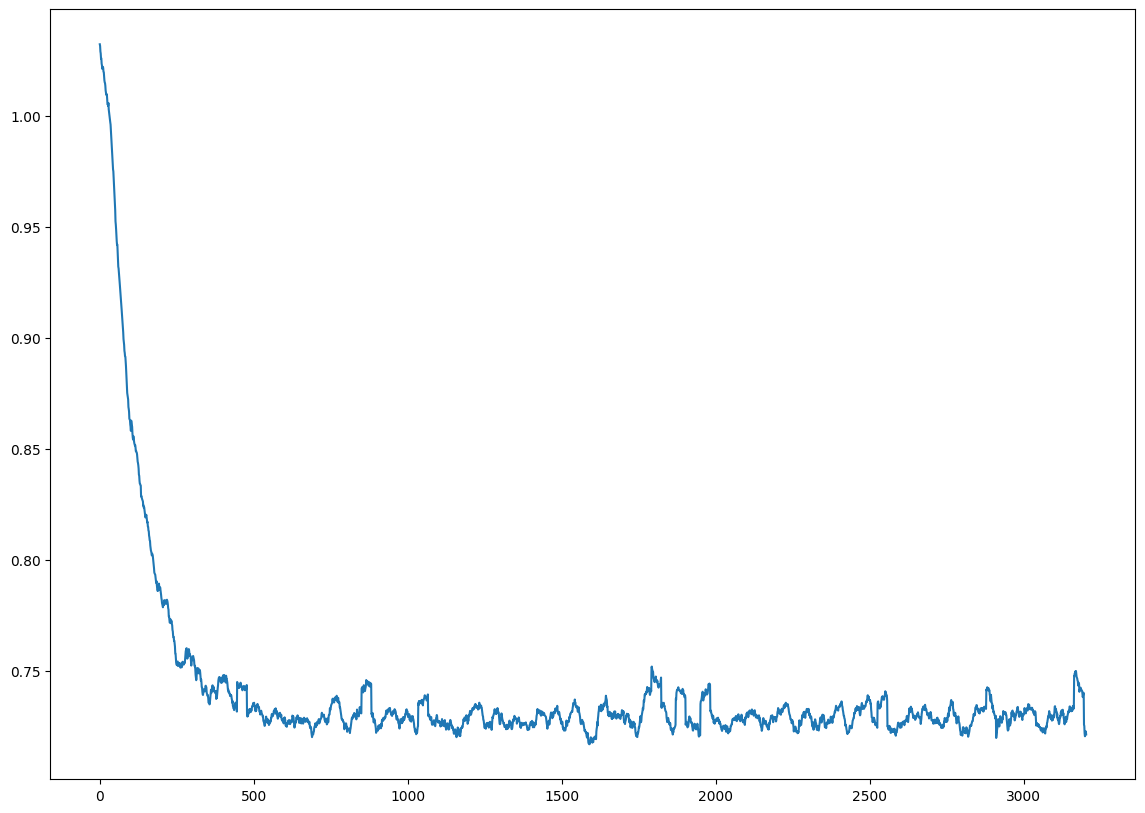

In [ ]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);